# Week 7: ReverseNet
### (A very silly but pedagogically useful attention network)

Transformers are sequence-to-sequence models, primarily designed to operate on complex datasets in natural language processing, computer vision, or more exotic applications.  However, we can conceptualize much simpler sequence-to-sequence tasks.  For example, one very simple sequence-to-sequence task is to simply reverse the order of the input sequence.  This turns out to be a bit difficult for a variety of different architectures: first, we can presume that we'll have variable length sequences, and so a multilayer perceptron will not work for this straightaway.  This turns out to be somewhat challenging for RNNs as well, because the entire sequence has to be stored in the RNN's memory, and then recalled in reverse order.  (This is an obvious case where "normal" computing has the edge over machine learning: this task is easily done with either arrays or stacks).

However, this is a task that we can learn to do with attention networks (I am loathe to call these transformers because what we will be doing is much simpler).  Indeed, it is easy to see precisely what behavior we would like attention to do: the first position in the output sequence should attend to the last position in the input sequence, the second to the second to last, and so on.  Can we learn to do this simply from paired input and output sequences?  

## Sequences to reverse
What sequences shall we apply this to?  One very simple case would be to reverse 1D real valued functions.  To that end, we can create a method that randomly generates a 1D real valued function of random length (in this case from a Gaussian Process), as well as its inverse.

/tmp/ipykernel_113592/1439553034.py:14: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)
  L = torch.cholesky(K + 1e-5*torch.eye(K.shape[0]))


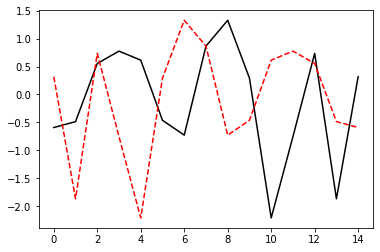

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

class DataGenerator:
    def __init__(self):
        pass    
    
    def __call__(self,n_in):
        x = torch.linspace(0,n_in-1,n_in)
        D = torch.cdist(x.view(-1,1),x.view(-1,1))
        l = np.random.randn()
        K = torch.exp(-(D/l)**2)
        L = torch.cholesky(K + 1e-5*torch.eye(K.shape[0]))
        v = L @ torch.randn(L.shape[1])
        v_reverse = torch.from_numpy(v.numpy()[::-1].copy())
        return v,v_reverse

generator = DataGenerator()
v,v_reverse = generator(15)

plt.plot(v,'k-')
plt.plot(v_reverse,'r--')

## Positional Encoding

Again, we would like to train a neural network to take as input the variable length sequence $\vec{v}_i$ and return its reversal.  

Because these functions are random, we would expect that the actual function values themselves will not be very informative for the purposes of reordering: there's not really a correlation between the function value and where it appears in the domain.  As such, we won't view the function values themselves as features as we would for a proper transformer.  Instead, we'll rely solely on the *positional encoding* to act as our feature.  

There are many versions of plausible positional encodings.  A popular choice in the context of transformers is to encode the position through applying sinusoids of varying frequencies to the sequence position.  This is roughly equivalent to encoding the sequence index in binary.  Alternatively, positional encodings can be learned.  However, for our purposes it will be useful to use the simple encoding scheme of *index normalized by sequence length*
$$
\vec{x}_\text{Enc,i} = \frac{i}{d_{in}},
$$
where $i$ is the sequence index.  The resulting encoding vector is zero at the zero-th position and one at the last.  Note that this choice throws away the objective notion of distance, which one could imagine to be useful for more complicated language modelling tasks where that actual objective distance might be an important indicator of, say, how related two words are.  In our task that distance is not important, and the simple encoding of relative position that the above equation affords works very well.  **Write a function that takes a sequence length $n_{in}$ and produces the positional encoding.  (This should be basically a one-liner)**

In [2]:
def get_positional_encoding(n_in):
    enc = torch.Tensor([[i/n_in] for i in range(n_in)])
    return enc # Implement positional encoding in range [0,1]

In [16]:
get_positional_encoding(25)

tensor([[0.0000],
        [0.0400],
        [0.0800],
        [0.1200],
        [0.1600],
        [0.2000],
        [0.2400],
        [0.2800],
        [0.3200],
        [0.3600],
        [0.4000],
        [0.4400],
        [0.4800],
        [0.5200],
        [0.5600],
        [0.6000],
        [0.6400],
        [0.6800],
        [0.7200],
        [0.7600],
        [0.8000],
        [0.8400],
        [0.8800],
        [0.9200],
        [0.9600]])

### Important note
One effect of only using positional encodings as features (and not the function values themselves) is that we can generate the output sequences all at once: there's no need to build sequences one output at a time, because that output will not be used as input by the next sequence element.  


## Key and query networks
Let's begin to think about network architecture.  Again, our goal is to take an input sequence, augment it with a positional encoding and output the reversed sequence.  Let's hypothesize that this can be done 
as follows:
$$
\vec{v}_{reversed} = \text{Softmax}\left(\frac{Q K^T}{d_k}\right) \vec{v}
$$
where 
$$
Q = q(\vec{x}_\text{Enc}) \in \mathbb{R}^{d_{in} \times d_k}
$$
$$
K = k(\vec{x}_\text{Enc}) \in \mathbb{R}^{d_{in} \times d_k}.
$$
The functions $q(\cdot)$ and $k(\cdot)$ are neural networks that act in a position-wise fashion: they should accept as input a feature and output a query or key vector at that position.  Applying this function to every element in the sequence produces $Q$ and $K$.  Again, we're not using $\vec{v}$ as a feature, so these can simply act on the positional encodings.  

**Create both a key and query function.  These can be quite simple: perhaps an MLP with one hidden layer that accepts a sequence of positional encodings and outputs a matrix of size $d_{in} \times d_k$**

In [20]:
class KeyNet(torch.nn.Module):
    def __init__(self,d_k, d_h):
        super(KeyNet, self).__init__()
        
        self.L1 = torch.nn.Linear(1, d_h)
        self.L2 = torch.nn.Linear(d_h, d_k)
        
    def forward(self,X):
        X = self.L1(X)
        X = torch.relu(X)
        X = self.L2(X)
        
        return X
    
class QueryNet(torch.nn.Module):
    def __init__(self,d_k, d_h):
        super(QueryNet, self).__init__()
        
        self.L1 = torch.nn.Linear(1, d_h)
        self.L2 = torch.nn.Linear(d_h, d_k)
       
    def forward(self,X):
        X = self.L1(X)
        X = torch.relu(X)
        X = self.L2(X)
        
        return X

## The ReverseNet
Now that we have a means of generating keys and queries, all we need to do is to implement the attention function.  **Implement a torch module that**
- takes as input a variable length sequence
- computes the positional encoding of input and output sequence (are they different?) 
- uses that encoding to produce a key matrix for the input sequence and a query matrix for the output sequence
- computes the scaled dot-product attention matrix
- applies the attention matrix to the input sequence to produce the output sequence

In [21]:
class Reverser(torch.nn.Module):
    def __init__(self,d_k, d_h):
        # This init method should initialize key and query networks
        super(Reverser, self).__init__()
        self.d_k = d_k
        self.d_h = d_h
        self.query = QueryNet(self.d_k,self.d_h)
        self.key = KeyNet(self.d_k,self.d_h)
        
        
    def forward(self,V):
        enc = get_positional_encoding(len(V))
        q = self.query(enc)
        k = self.key(enc)
        
        m = torch.nn.Softmax(dim=1)
        attn = m(torch.matmul(q,torch.t(k))/self.d_k)
        
        rev = torch.matmul(attn,V)
        return rev, attn


reverser = Reverser(100, 50) # You may wish to add arguments to the constructor

## Training
Of course this network will not yet be skillful at reversing sequences because it hasn't been trained.  We can implement a simple training loop

In [22]:
optimizer = torch.optim.Adam(reverser.parameters(),lr=1e-2)
batch_size = 25
n_epochs = 1000

for i in range(n_epochs):
    optimizer.zero_grad()
    loss = 0.0
    for j in range(batch_size):
        d_in = np.random.randint(20,30)
        v,v_reverse = generator(d_in)

        v_reverse_predicted, attn = reverser(v)
        loss += (((v_reverse_predicted - v_reverse )**2).mean())
        
    loss.backward()
    optimizer.step()
    if i%50==0:
        print(f"Iteration: {i}, Loss: {loss.item():.02f}")


Iteration: 0, Loss: 21.75
Iteration: 50, Loss: 21.32
Iteration: 100, Loss: 16.57
Iteration: 150, Loss: 8.91
Iteration: 200, Loss: 10.14
Iteration: 250, Loss: 6.87
Iteration: 300, Loss: 8.04
Iteration: 350, Loss: 5.44
Iteration: 400, Loss: 5.16
Iteration: 450, Loss: 5.24
Iteration: 500, Loss: 3.93
Iteration: 550, Loss: 2.83
Iteration: 600, Loss: 2.84
Iteration: 650, Loss: 1.81
Iteration: 700, Loss: 2.29
Iteration: 750, Loss: 1.59
Iteration: 800, Loss: 1.98
Iteration: 850, Loss: 1.17
Iteration: 900, Loss: 0.86
Iteration: 950, Loss: 0.95


Having successfully trained the network, we can look at some output!

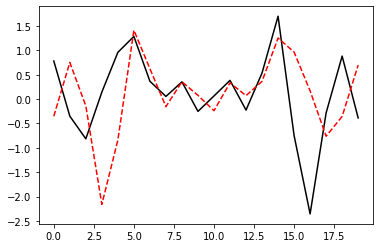

In [23]:
v,_ = generator(20)
v_r, attn = reverser(v)
plt.plot(v,'k-')
plt.plot(v_r.detach(),'r--')


Wow!  We have managed to turn a simple numpy call into a rather complicated neural network, but it works.  However, despite the simplicity of the task, this is perhaps useful for checking your intuition regarding how attention works.  In particular, what do you suppose the attention matrix 
$$
A = \text{Softmax}\left(\frac{Q K^T}{d_k}\right)
$$
looks like for this problem?  **Spend a moment talking to your neighbor or making a sketch**.  **Then modify the Reverser class' forward method to output not not only the reversed sequence, but also the attention matrix.  Plot that matrix (plt.imshow works well for this) for a few examples and see if this aligns with your intuition.**  

*The attention matrix should be an inverted identity matrix, or a flip matrix*

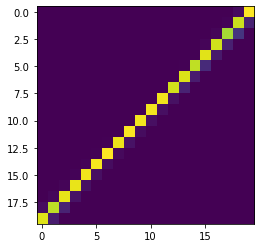

In [24]:
v,_ = generator(20)
v_r, attn = reverser(v)
plt.imshow(attn.detach())